In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from utils import normalize
from torch.utils.data import DataLoader

from mod_moving_mnist import ModMovingMNISTDataset
from mpnnlstm import NextFramePredictorS2S
from model import MPNNLSTM, MPNNLSTMI

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

def collate_fn(batch):
    return batch[0]

input_features = 1
input_timesteps = 4
output_timesteps = 10

# Create a dataset using the modified MovingMNIST
mnist_kwargs = dict(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    n_digits=1,
    gap=0,
    canvas_size=(32, 32),
    digit_size=(18, 18),
    pixel_noise=0.05,
    velocity_noise=0.0#1  # 0.15
)

# Create a train set (500), test set (50), and validation set (50)
data_train = ModMovingMNISTDataset(200, **mnist_kwargs)
data_test = ModMovingMNISTDataset(50, **mnist_kwargs)
data_val = ModMovingMNISTDataset(50, **mnist_kwargs)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True)
loader_val = DataLoader(data_val, batch_size=1, shuffle=False)

In [22]:
from mpnnlstm import NextFramePredictor

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
model_kwargs = dict(
    hidden_size=16,
    dropout=0.1,
    n_layers=3
)


model = NextFramePredictorS2S(
    thresh=0.1,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=device,
    output_timesteps=output_timesteps,
    remesh_input=False,
    model_kwargs=model_kwargs)

model.get_n_params()

12641

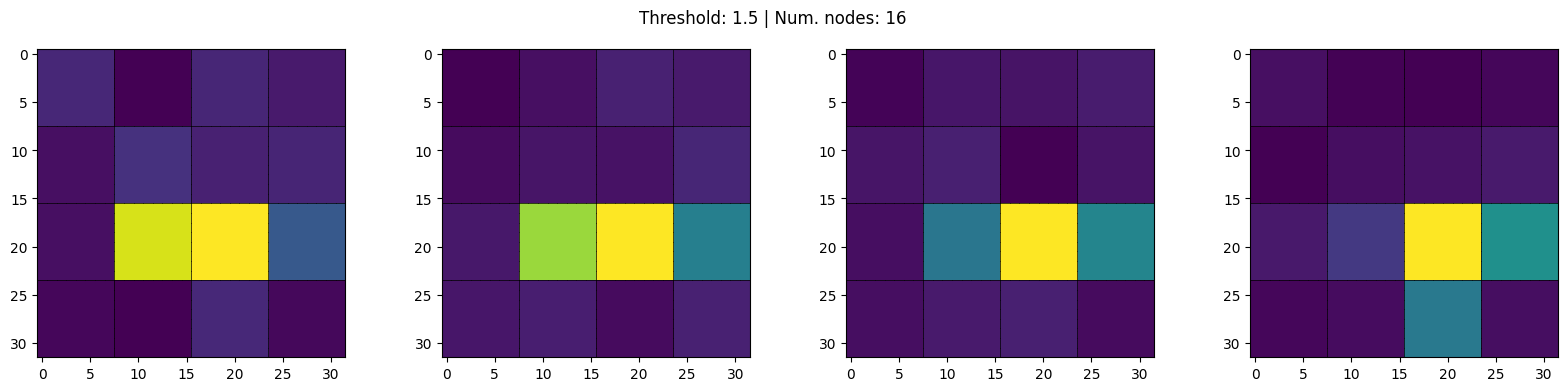

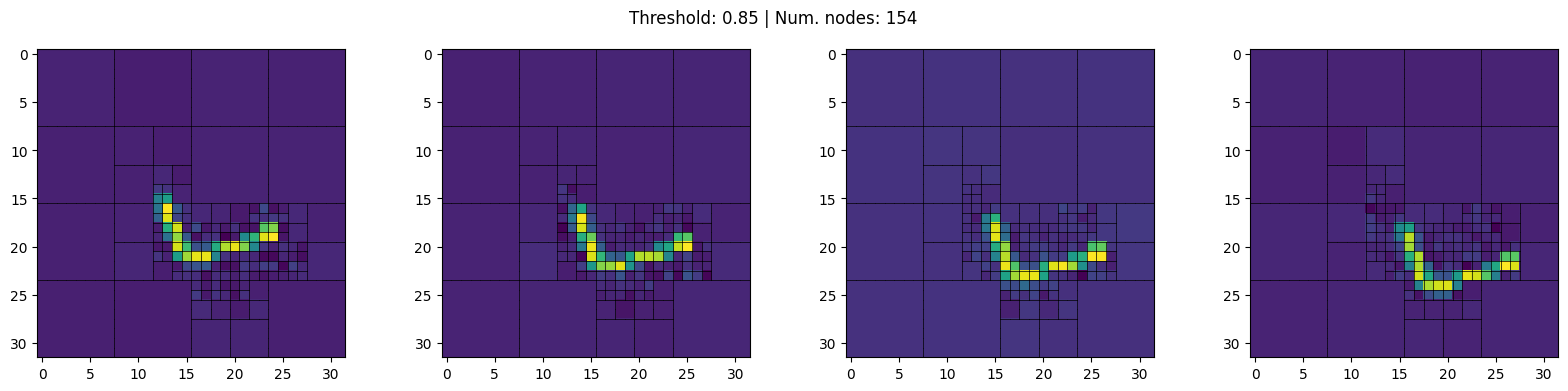

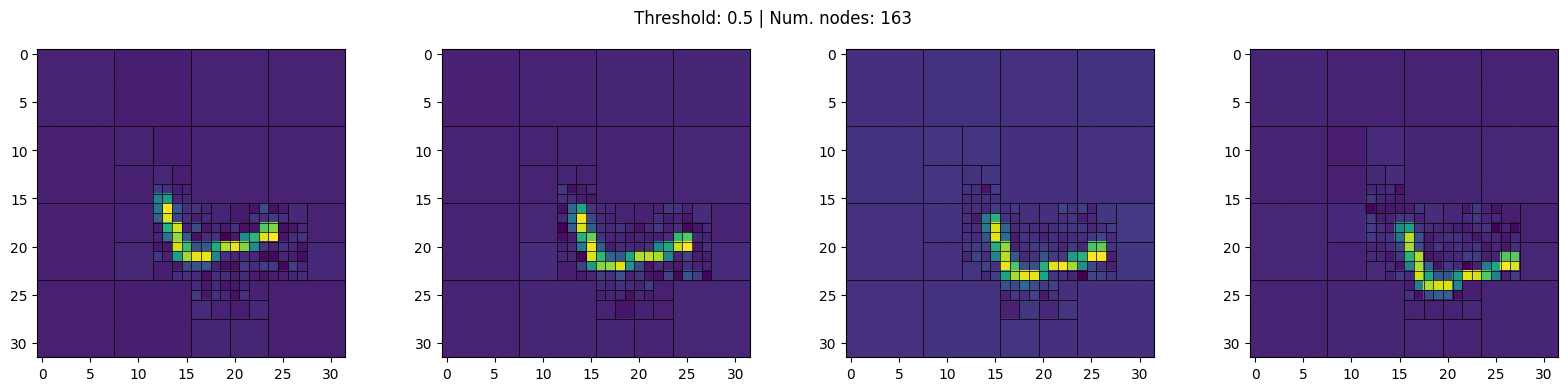

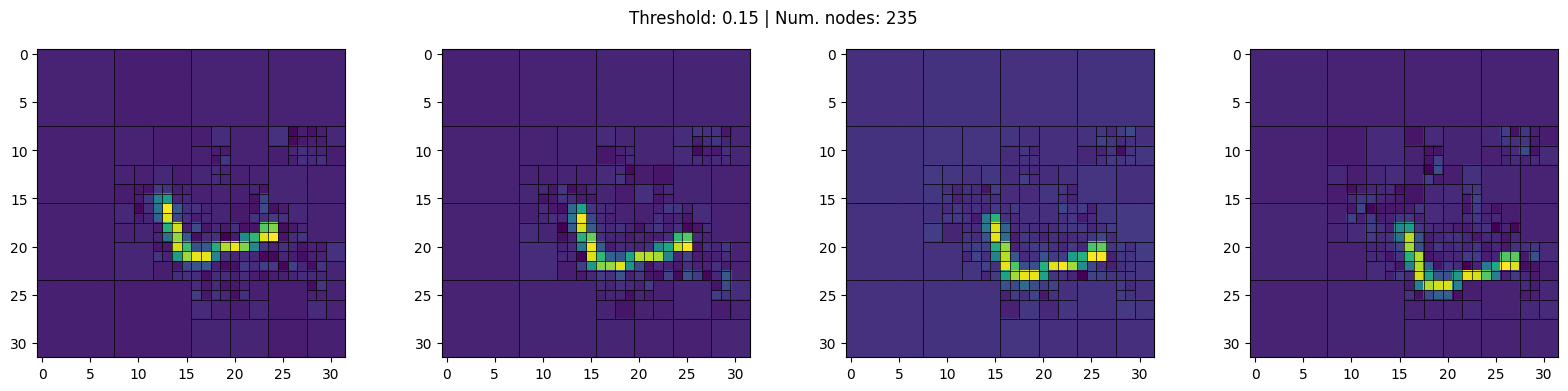

In [5]:
x, _ = next(iter(loader_val))
x = x.squeeze(0)

fig, axs = model.test_threshold(x, thresh=1.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.85)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.15)
plt.show()

In [27]:
import cProfile
loader_profile = DataLoader(data_train, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(range(10)))
cProfile.run('model.train(loader_profile, loader_profile, lr=0.01, n_epochs=1)', sort=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.42it/s]

Epoch 0 train MSE: 0.2151, test MSE: 0.2235, lr: 0.0100, time_per_epoch: 5.7
Finished in 0.09435171683629354 minutes
         5053339 function calls (4841411 primitive calls) in 5.678 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    1.006    0.101    1.006    0.101 {method 'run_backward' of 'torch._C._EngineBase' objects}
      220    0.664    0.003    0.745    0.003 graph_functions.py:203(get_adj)
      220    0.367    0.002    0.424    0.002 graph_functions.py:98(quadtree_decompose)
    12480    0.362    0.000    0.362    0.000 {method 'scatter_add_' of 'torch._C._TensorBase' objects}
     6240    0.252    0.000    0.374    0.000 gcn_conv.py:33(gcn_norm)
     1420    0.205    0.000    0.205    0.000 {method 'to_dense' of 'torch._C._TensorBase' objects}
      220    0.177    0.001    0.275    0.001 graph_functions.py:33(create_graph_structure)
     6240    0.143    0.000    1.524    0.000 gcn_conv.py:168(forwar

In [23]:
model.train(loader_train, loader_test, lr=0.01, n_epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch 0 train MSE: 0.3058, test MSE: 0.2973, lr: 0.0100, time_per_epoch: 74.4


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


Epoch 1 train MSE: 0.2865, test MSE: 0.2661, lr: 0.0100, time_per_epoch: 74.6


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]


Epoch 2 train MSE: 0.2854, test MSE: 0.2842, lr: 0.0095, time_per_epoch: 73.7


 96%|████████████████████████████████████████████████████████████████████████████████████▉    | 191/200 [00:58<00:02,  3.39it/s]/Users/zach/Documents/Quadtree-MPNNLSTM/mpnnlstm.py:423: UserWarning: Matrix multiplication in flatten() failed, trying again.
  warnings.warn('Matrix multiplication in flatten() failed, trying again.')
100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]


Epoch 3 train MSE: 0.2795, test MSE: 0.2705, lr: 0.0095, time_per_epoch: 73.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.79it/s]


Epoch 4 train MSE: 0.2734, test MSE: 0.2758, lr: 0.0095, time_per_epoch: 73.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


Epoch 5 train MSE: 0.2609, test MSE: 0.2580, lr: 0.0090, time_per_epoch: 72.6


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s]


Epoch 6 train MSE: 0.2521, test MSE: 0.2514, lr: 0.0090, time_per_epoch: 71.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.68it/s]


Epoch 7 train MSE: 0.2434, test MSE: 0.2357, lr: 0.0090, time_per_epoch: 71.9


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.59it/s]


Epoch 8 train MSE: 0.2336, test MSE: 0.2267, lr: 0.0086, time_per_epoch: 71.4


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.75it/s]


Epoch 9 train MSE: 0.2290, test MSE: 0.2244, lr: 0.0086, time_per_epoch: 71.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]


Epoch 10 train MSE: 0.2349, test MSE: 0.2204, lr: 0.0086, time_per_epoch: 71.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 11 train MSE: 0.2331, test MSE: 0.2239, lr: 0.0081, time_per_epoch: 71.0


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.46it/s]


Epoch 12 train MSE: 0.2318, test MSE: 0.2239, lr: 0.0081, time_per_epoch: 70.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.77it/s]


Epoch 13 train MSE: 0.2313, test MSE: 0.2260, lr: 0.0081, time_per_epoch: 70.5


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.64it/s]


Epoch 14 train MSE: 0.2292, test MSE: 0.2290, lr: 0.0077, time_per_epoch: 70.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]


Epoch 15 train MSE: 0.2237, test MSE: 0.2225, lr: 0.0077, time_per_epoch: 70.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


Epoch 16 train MSE: 0.2247, test MSE: 0.2134, lr: 0.0077, time_per_epoch: 70.0


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


Epoch 17 train MSE: 0.2229, test MSE: 0.2367, lr: 0.0074, time_per_epoch: 69.9


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


Epoch 18 train MSE: 0.2260, test MSE: 0.2251, lr: 0.0074, time_per_epoch: 69.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


Epoch 19 train MSE: 0.2271, test MSE: 0.2126, lr: 0.0074, time_per_epoch: 69.7
Finished in 23.217649181683857 minutes


<Axes: >

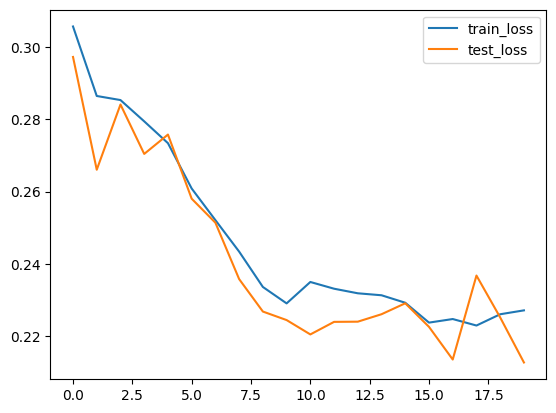

In [24]:
model.loss.plot() 

In [25]:
y_hat = model.predict(loader_val)

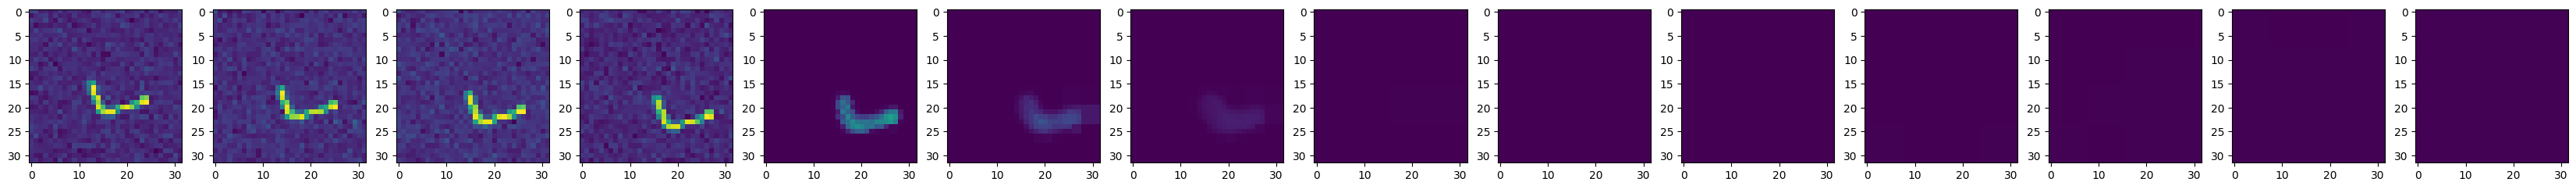

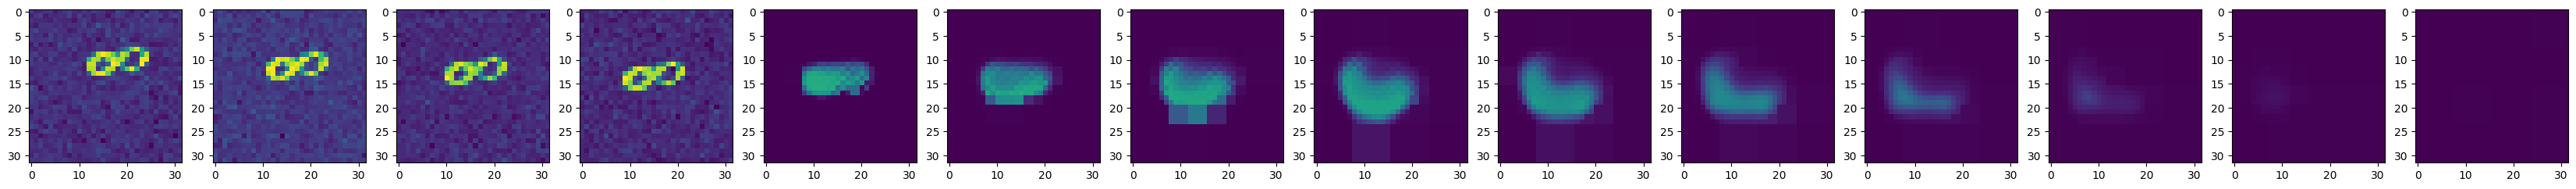

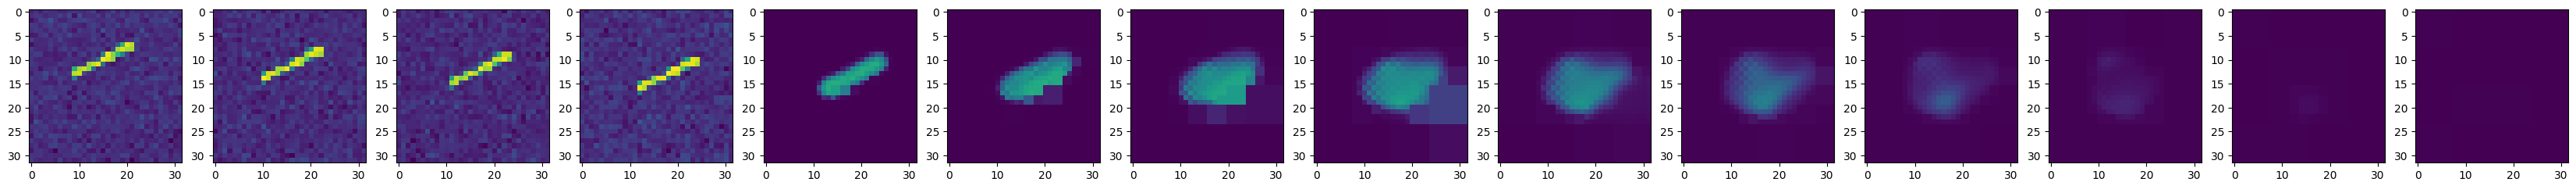

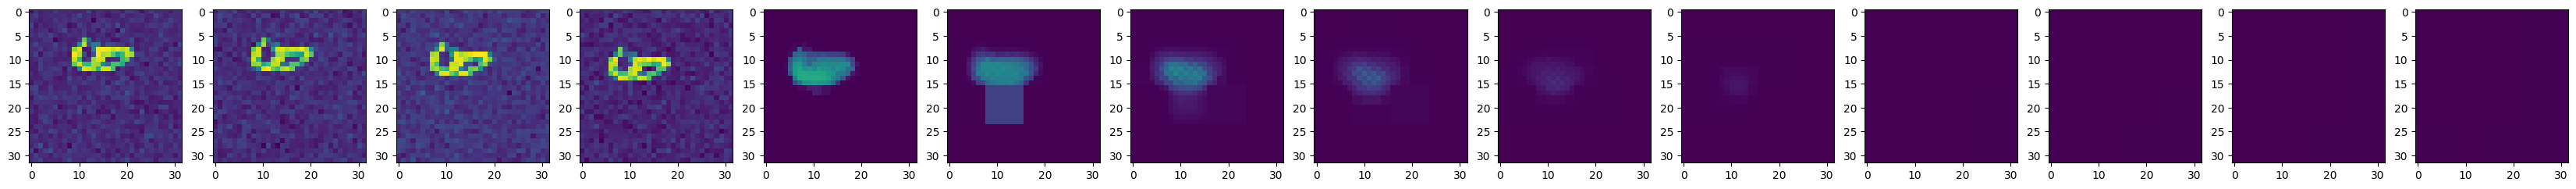

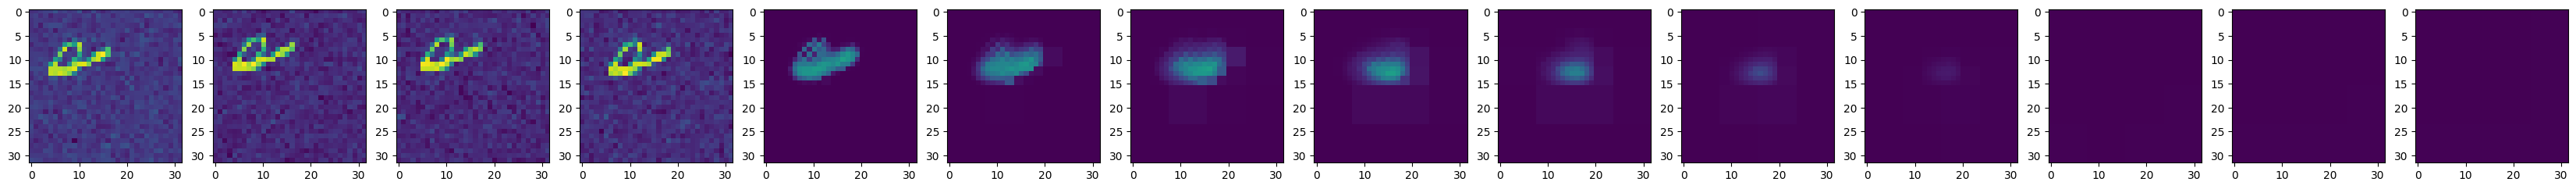

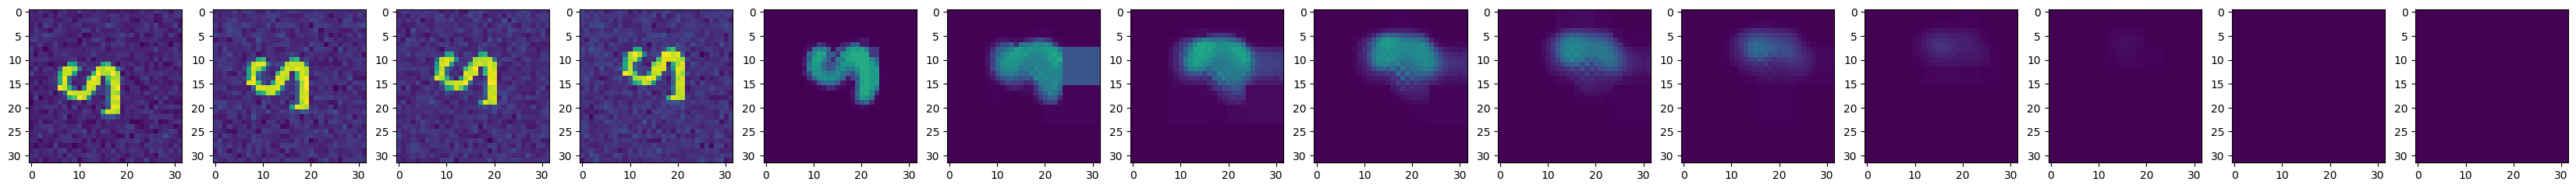

In [26]:
# Plot some example 
num_frames = 6

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(loader_val.dataset.x[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][..., 0], vmin=0, vmax=1)  # Prediction

In [ ]:
model.loss.iloc[1:].plot()